In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import sys
import os
import time
import pickle
import random

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.optim import Adam
from sklearn import metrics
from collections import OrderedDict 

sys.path.append(os.path.abspath('..'))

import datasets
import utils.more_torch_functions as mtf
from utils.modules import Parallel, MaxLayer
from utils.custom_activations import StepActivation
from utils.custom_loss import AsymBCELoss
from utils.misc import train_model, Figures
from compiling_nn.build_odd import compile_nn
from compiling_nn.utils_odd import pickle_bdd, unpickle_bdd

seed = 2872
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

SAVE_PATH = os.path.join(os.path.abspath('..'), "backup")
PKL_PATH = os.path.join(SAVE_PATH, "bdd")
PTH_PATH = os.path.join(SAVE_PATH, "nn")
METRIC_PATH = os.path.join(SAVE_PATH, "metrics")

## Load data

In [3]:
dataset = datasets.CompasDataset

np_x, np_y = dataset.get_dataset(balancing=True, discretizing=True, hot_encoding=True)
x_data, y_data = torch.Tensor(np_x), torch.Tensor(np_y)
input_size = x_data.size(1)
print(x_data.size())

torch.Size([4966, 18])


In [4]:
def train_eval_model(x_train, y_train, x_valid, y_valid, model, criterion, optimizer, epochs=50, metrics_average="binary"):
    train_model(x_train, y_train, model, criterion, optimizer, epochs)
    model.eval()
    pred_train = model(x_train).detach()
    pred_valid = model(x_valid).detach()

    p_train, r_train, f_train, _ = metrics.precision_recall_fscore_support(y_train, pred_train, beta=1, average=metrics_average, labels=[0,1])
    p_valid, r_valid, f_valid, _ = metrics.precision_recall_fscore_support(y_valid, pred_valid, beta=1, average=metrics_average, labels=[0,1])

    return f_train, p_train, r_train, f_valid, p_valid, r_valid

def print_eval(x_train, y_train, x_valid, y_valid, model, criterion, optimizer):
    f_train, p_train, r_train, f_valid, p_valid, r_valid = train_eval_model(x_train, y_train, x_valid, y_valid, model, criterion, optimizer)
    print(
        f"{'':<15}{'Train':^15}{'Valid':^15}",
        f"{'F1 score':<15}{f_train:^15.3f}{f_valid:^15.3f}",
        f"{'Precision':<15}{p_train:^15.3f}{p_valid:^15.3f}",
        f"{'Rappel':<15}{r_train:^15.3f}{r_valid:^15.3f}",
        sep="\n",
    )

## Network

In [5]:
class nApxNet(nn.Module):
    def __init__(self, n, hl=3) -> None:
        super().__init__()

        self.n_apx = n
        self.net = nn.Sequential(OrderedDict([
            ('nets', Parallel(OrderedDict([
                (f'apx{i}', ApproxNet(hl)) for i in range(1, self.n_apx+1)
            ]))),
            ('or_', MaxLayer()),
        ]))


    def forward(self, input):
        return self.net(input)
    
    def add_apx(self, module):
        self.n_apx += 1
        self.net.nets.add_module(f'apx{self.n_apx}', module)
    
class ApproxNet(nn.Module):
    def __init__(self, hl1):
        super().__init__()
        self.nn = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(input_size,hl1)),
            ('a1', StepActivation()),
            ('l2', nn.Linear(hl1,5)),
            ('a2', StepActivation()),
            ('l3', nn.Linear(5,1)),
            ('a3', StepActivation()),
        ]))        

    def forward(self, x):
        x = self.nn(x)

        return x

## Exp

In [6]:
def train_compile(x_train, y_train, x_valid, y_valid, hidden_neurons):
    exp_folder = "train_compile"
    os.makedirs(os.path.join(PTH_PATH, exp_folder), exist_ok=True)
    d_metrics = {}
    len_hn = len(hidden_neurons)
    for ihn, num_neurons in enumerate(hidden_neurons):
        model = nApxNet(1, num_neurons)
        criterion = nn.BCELoss()
        optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)

        f1t, pt, rt, f1v , pv, rv = train_eval_model(x_train, y_train, x_valid, y_valid, model, criterion, optimizer)

        start = time.perf_counter()
        bdd = compile_nn(model.net.nets.apx1)
        time_to_build = time.perf_counter() - start
        bdd_size = len(list(bdd.dfs_postorder()))

        modelname = f"1apx{num_neurons}hl"
        torch.save(model.state_dict(), os.path.join(PTH_PATH, exp_folder, f"{modelname}.pth"))
        os.makedirs(os.path.join(PKL_PATH, exp_folder, modelname), exist_ok=True)
        pickle_bdd(bdd, os.path.join(PKL_PATH, exp_folder, modelname, "apx1.pkl"))
        print(f"DONE {num_neurons}")

        d_metrics.setdefault(('train', 'f1'), np.empty((1, len_hn)))[0, ihn] = f1t
        d_metrics.setdefault(('valid', 'f1'), np.empty((1, len_hn)))[0, ihn] = f1v
        d_metrics.setdefault(('train', 'precision'), np.empty((1, len_hn)))[0, ihn] = pt
        d_metrics.setdefault(('valid', 'precision'), np.empty((1, len_hn)))[0, ihn] = pv
        d_metrics.setdefault(('train', 'recall'), np.empty((1, len_hn)))[0, ihn] = rt
        d_metrics.setdefault(('valid', 'recall'), np.empty((1, len_hn)))[0, ihn] = rv
        d_metrics.setdefault('bdd_size', np.empty((1, len_hn)))[0, ihn] = bdd_size
        d_metrics.setdefault('time', np.empty((1, len_hn)))[0, ihn] = time_to_build

    with open(os.path.join(METRIC_PATH, f"{exp_folder}.pkl"), 'wb') as f:
        pickle.dump(d_metrics, f)
    return d_metrics

def train_expand(x_train, y_train, x_valid, y_valid, hidden_neurons, n_apx):
    exp_folder = "train_expand"
    os.makedirs(os.path.join(PTH_PATH, exp_folder), exist_ok=True)
    d_metrics = dict()
    len_hn = len(hidden_neurons)
    for ihn, num_neurons in enumerate(hidden_neurons):
        model = nApxNet(1, hl=num_neurons)
        for iapx in range(n_apx):
            criterion = nn.BCELoss()
            optimizer = Adam(model.net.nets.parameters(), lr=1e-2, weight_decay=1e-6)

            f1t, pt, rt, f1v , pv, rv = train_eval_model(x_train, y_train, x_valid, y_valid, model, criterion, optimizer)
            
            d_metrics.setdefault(('train', 'f1'), np.empty((n_apx, len_hn)))[iapx, ihn] = f1t
            d_metrics.setdefault(('valid', 'f1'), np.empty((n_apx, len_hn)))[iapx, ihn] = f1v
            d_metrics.setdefault(('train', 'precision'), np.empty((n_apx, len_hn)))[iapx, ihn] = pt
            d_metrics.setdefault(('valid', 'precision'), np.empty((n_apx, len_hn)))[iapx, ihn] = pv
            d_metrics.setdefault(('train', 'recall'), np.empty((n_apx, len_hn)))[iapx, ihn] = rt
            d_metrics.setdefault(('valid', 'recall'), np.empty((n_apx, len_hn)))[iapx, ihn] = rv

            modelname = f"{iapx+1}apx{ihn}hl"
            torch.save(model.state_dict(), os.path.join(PTH_PATH, exp_folder, f"{modelname}.pth"))

            module = ApproxNet(num_neurons)
            model.add_apx(module)

    with open(os.path.join(METRIC_PATH, f"{exp_folder}.pkl"), 'wb') as f:
        pickle.dump(d_metrics, f)
    return d_metrics

def freeze_expand(x_train, y_train, x_valid, y_valid, hidden_neurons, n_apx):
    exp_folder = "freeze_expand_asym"
    os.makedirs(os.path.join(PTH_PATH, exp_folder), exist_ok=True)
    d_metrics = dict()
    len_hn = len(hidden_neurons)
    for ihn, num_neurons in enumerate(hidden_neurons):
        model = nApxNet(1, hl=num_neurons)
        criterion = AsymBCELoss(1.2) # HERE
        module = model.net.nets.apx1
        for iapx in range(n_apx):
            optimizer = Adam(module.parameters(), lr=1e-2, weight_decay=1e-6)

            f1t, pt, rt, f1v , pv, rv = train_eval_model(x_train, y_train, x_valid, y_valid, model, criterion, optimizer, epochs=500, metrics_average=None)

            d_metrics.setdefault(('train', 'f1'), np.empty((n_apx, len_hn)))[iapx, ihn] = f1t.mean()
            d_metrics.setdefault(('valid', 'f1'), np.empty((n_apx, len_hn)))[iapx, ihn] = f1v.mean()
            d_metrics.setdefault(('train', 'precision0'), np.empty((n_apx, len_hn)))[iapx, ihn] = pt[0]
            d_metrics.setdefault(('valid', 'precision0'), np.empty((n_apx, len_hn)))[iapx, ihn] = pv[0]
            d_metrics.setdefault(('train', 'recall0'), np.empty((n_apx, len_hn)))[iapx, ihn] = rt[0]
            d_metrics.setdefault(('valid', 'recall0'), np.empty((n_apx, len_hn)))[iapx, ihn] = rv[0]
            d_metrics.setdefault(('train', 'precision1'), np.empty((n_apx, len_hn)))[iapx, ihn] = pt[1]
            d_metrics.setdefault(('valid', 'precision1'), np.empty((n_apx, len_hn)))[iapx, ihn] = pv[1]
            d_metrics.setdefault(('train', 'recall1'), np.empty((n_apx, len_hn)))[iapx, ihn] = rt[1]
            d_metrics.setdefault(('valid', 'recall1'), np.empty((n_apx, len_hn)))[iapx, ihn] = rv[1]

            modelname = f"{iapx+1}apx{hidden_neurons[ihn]}hl"
            torch.save(model.state_dict(), os.path.join(PTH_PATH, exp_folder, f"{modelname}.pth"))

            module = ApproxNet(num_neurons)
            model.add_apx(module)

    with open(os.path.join(METRIC_PATH, f"{exp_folder}.pkl"), 'wb') as f:
        pickle.dump(d_metrics, f)
    return d_metrics

In [7]:
train_index, valid_index = torch.utils.data.random_split(range(x_data.size(0)), [0.9, 0.1])

x_train, y_train = x_data[train_index], y_data[train_index]
x_valid, y_valid = x_data[valid_index], y_data[valid_index]

hidden_neurons = [3,5,7,10,15]
n_apx_max = 3

# d_metrics = train_compile(x_train, y_train, x_valid, y_valid, hidden_neurons)
# d_metrics = train_expand(x_train, y_train, x_valid, y_valid, hidden_neurons, n_apx_max)
d_metrics = freeze_expand(x_train, y_train, x_valid, y_valid, hidden_neurons, n_apx_max)

Figures(children=(VBox(children=(RadioButtons(options=('Approx', 'Neurons'), value='Approx'), ToggleButtons(in…

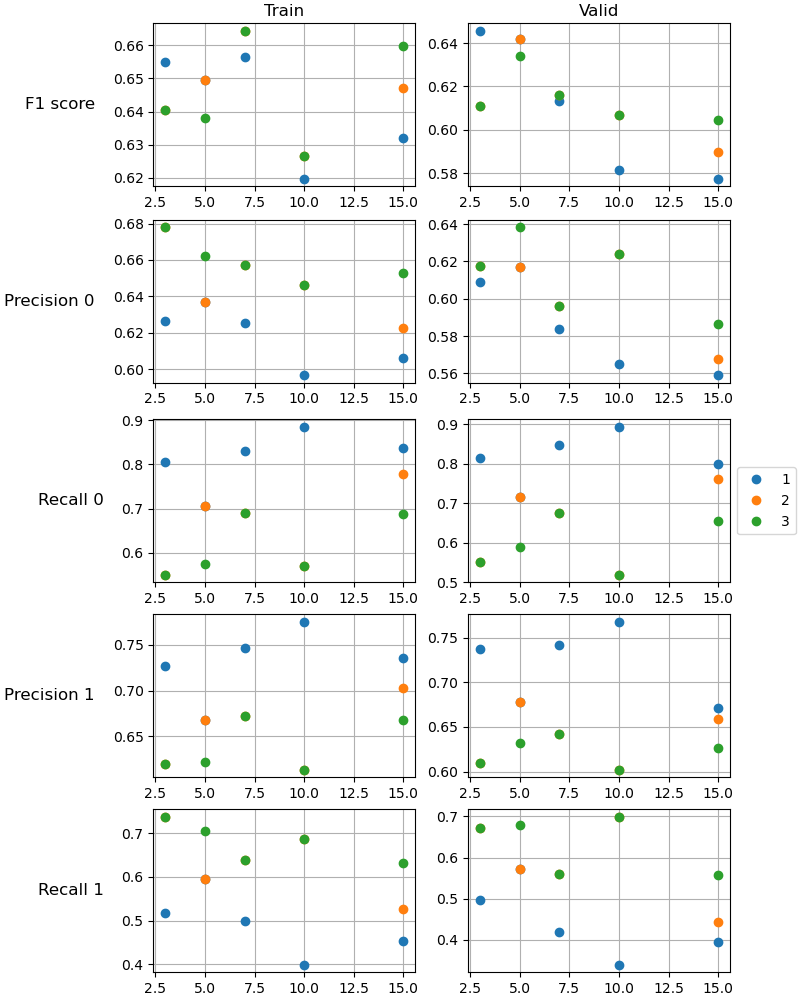

In [8]:
%matplotlib widget

x_axis = hidden_neurons

cols = ["Train", "Valid"]
rows = ["F1 score", "Precision 0", "Recall 0", "Precision 1", "Recall 1"]

figs = Figures(x_axis, list(d_metrics.values()), options=["Approx", "Neurons"], nrows=5, ncols=2, linestyle='None', marker='o')
figs.annotate(cols, rows)
figs.legend(row=2, col=1, loc='center left', bbox_to_anchor=(1, 0.5))
figs.plot_autocenter(False)
display(figs)

#### Notes

résultats idéaux

Classe 0 : 
- très bon rappel -> un maximum de 0 sont bien classés
- précision peu importante -> des 1 peuvent être classés en tant que 0

Classe 1 : 
- très bonne précision -> idem rappel 0 (peu de zéro mal classés en 1)
- rappel peu important -> idem précision 0 (des 1 peuvent être manqués)

In [9]:
# def custom_plot(ax, x_axis, y_axis, title=None, label=None, labels=None, marker='.'):
#     ax.plot(x_axis, y_axis, marker=marker, label=label)
#     if title is not None:
#         ax.set_title(title)
#     if labels is not None:
#         for x, y, label in zip(x_axis, y_axis, labels):
#             ax.annotate(label, (x, y), textcoords="offset points", xytext=(0,2), ha="center")
#     if label:
#         ax.legend()

# fig, axs = plt.subplots(2,2)
# custom_plot(axs[0, 0], hidden_neurons, d_metrics["bdd_size"][0,:], "bdd size / hidden layer size")
# custom_plot(axs[0, 1], hidden_neurons, d_metrics["time"][0,:], "time / hidden layer size")
# custom_plot(axs[1, 0], d_metrics[('train', 'precision')][0,:], d_metrics["bdd_size"][0,:], "bdd size / precision train", label="1", labels=hidden_neurons)
# custom_plot(axs[1, 0], d_metrics[('train', 'recall')][0,:], d_metrics["bdd_size"][0,:], label="0", labels=hidden_neurons)
# custom_plot(axs[1, 1], d_metrics[('valid', 'precision')][0,:], d_metrics["bdd_size"][0,:], "bdd size / precision valid", label="1", labels=hidden_neurons)
# custom_plot(axs[1, 1], d_metrics[('valid', 'recall')][0,:], d_metrics["bdd_size"][0,:], label="0", labels=hidden_neurons)

# fig.tight_layout()
# fig.subplots_adjust(left=0, top=1.2)

In [10]:
%matplotlib widget

from utils.test import Model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

def compute_metrics(pred_train, y_train, pred_valid, y_valid):
    p_train, r_train, f_train, _ = metrics.precision_recall_fscore_support(y_train, pred_train, beta=1, average=None, labels=[0,1])
    p_valid, r_valid, f_valid, _ = metrics.precision_recall_fscore_support(y_valid, pred_valid, beta=1, average=None, labels=[0,1])

    metrics_list = [
        f_train.mean(), f_valid.mean(),
        p_train[0], p_valid[0],
        r_train[0], r_valid[0],
        p_train[1], p_valid[1],
        r_train[1], r_valid[1],
    ]

    return metrics_list

test_np_x, test_np_y = dataset.get_dataset(balancing=True, discretizing=False, hot_encoding=True)
test_x_data = torch.Tensor(test_np_x)
test_y_data = torch.Tensor(test_np_y)
test_input_size = test_x_data.size(1)

test_x_train, y_train = test_x_data[train_index], test_y_data[train_index]
test_x_valid, y_valid = test_x_data[valid_index], test_y_data[valid_index]

# Random Forest
rf = RandomForestClassifier()

rf.fit(test_x_train, y_train.reshape(-1))

rf_pred_train = rf.predict(test_x_train)
rf_pred_valid = rf.predict(test_x_valid)

rf_metrics = compute_metrics(rf_pred_train, y_train, rf_pred_valid, y_valid)

# Gradient Boosting
gb = GradientBoostingClassifier()

gb.fit(test_x_train, y_train.reshape(-1))

gb_pred_train = gb.predict(test_x_train)
gb_pred_valid = gb.predict(test_x_valid)

gb_metrics = compute_metrics(gb_pred_train, y_train, gb_pred_valid, y_valid)

# Hist Gradient Boosting
hgb = HistGradientBoostingClassifier()

hgb.fit(test_x_train, y_train.reshape(-1))

hgb_pred_train = gb.predict(test_x_train)
hgb_pred_valid = gb.predict(test_x_valid)

hgb_metrics = compute_metrics(gb_pred_train, y_train, gb_pred_valid, y_valid)

# Neural network
net = Model(test_input_size)
crit = nn.BCELoss()
opt = Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)

train_model(test_x_train, y_train, net, crit, opt, max_epoch=500)

net_pred_train = net(test_x_train).detach().round()
net_pred_valid = net(test_x_valid).detach().round()

net_metrics = compute_metrics(net_pred_train, y_train, net_pred_valid, y_valid)

# Combined model and best approx
scores = d_metrics[("valid", "recall0")]
ind = np.unravel_index(scores.argmax(), scores.shape)

apx_num = ind[0] + 1
neurons_num = hidden_neurons[ind[1]]

apx = nApxNet(apx_num, neurons_num)
apxname = f"{apx_num}apx{neurons_num}hl.pth"
apx.load_state_dict(torch.load(os.path.join(PTH_PATH, "freeze_expand_asym", apxname)))
print(apxname)

apx_pred_train = apx(x_train).detach().round()
apx_pred_valid = apx(x_valid).detach().round()
co_pred_train = torch.maximum(net_pred_train, apx_pred_train)
co_pred_valid = torch.maximum(net_pred_valid, apx_pred_valid)

co_metrics = compute_metrics(co_pred_train, y_train, co_pred_valid, y_valid)

1apx10hl.pth


In [12]:
# vote classifier (hard)

classifier_results_train = [rf_pred_train, net_pred_train, apx_pred_train]
classifier_results_valid = [rf_pred_valid, net_pred_valid, apx_pred_valid]

classifier_results_train = np.stack([np.array(x).reshape((-1)) for x in classifier_results_train])
classifier_results_valid = np.stack([np.array(x).reshape((-1)) for x in classifier_results_valid])

vote_pred_train = np.where(classifier_results_train.sum(axis=0)>classifier_results_train.shape[0]/2, 1, 0)
vote_pred_valid = np.where(classifier_results_valid.sum(axis=0)>classifier_results_valid.shape[0]/2, 1, 0)

vote_metrics = compute_metrics(vote_pred_train, y_train, vote_pred_valid, y_valid)

# vote classifier (soft) (predict_proba)

In [13]:
tmp_metrics = compute_metrics(apx_pred_train, y_train, apx_pred_valid, y_valid)

print(tmp_metrics, net_metrics, rf_metrics, co_metrics, sep='\n')
# train / valid
# f1 p0 r0 p1 r1

[0.6795340489035098, 0.6425962255349102, 0.6487455197132617, 0.6060606060606061, 0.8080357142857143, 0.823045267489712, 0.7440476190476191, 0.7409638554216867, 0.5605381165919282, 0.48616600790513836]
[0.7560270628393221, 0.6911950852454285, 0.7204874333587205, 0.6474358974358975, 0.8446428571428571, 0.831275720164609, 0.8112798264642083, 0.7771739130434783, 0.6708520179372197, 0.5652173913043478]
[0.8525781457223172, 0.6946597251383073, 0.829308909242298, 0.6642857142857143, 0.8892857142857142, 0.7654320987654321, 0.8800773694390716, 0.7361111111111112, 0.8161434977578476, 0.6284584980237155]
[0.6961180265077858, 0.6672291459125379, 0.7043558850787767, 0.648854961832061, 0.6785714285714286, 0.6995884773662552, 0.6885813148788927, 0.688034188034188, 0.7139013452914799, 0.6363636363636364]


Figures(children=(VBox(children=(RadioButtons(options=('Approx', 'Neurons'), value='Approx'), ToggleButtons(in…

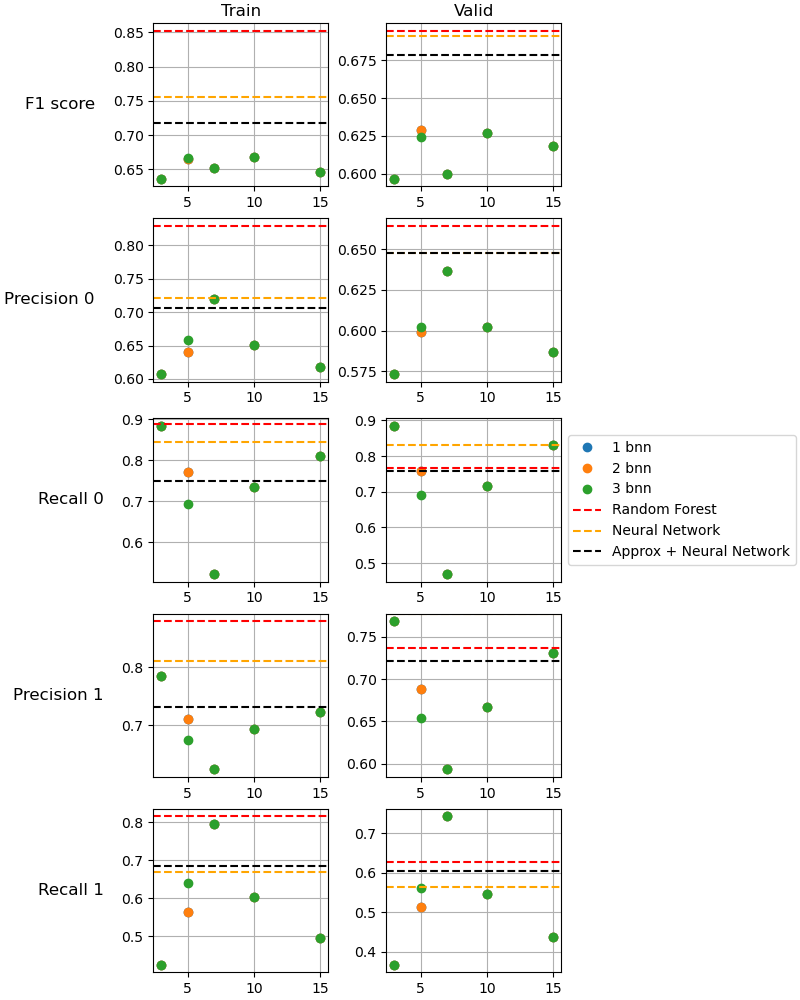

In [ ]:
%matplotlib widget

x_axis = hidden_neurons

cols = ["Train", "Valid"]
rows = ["F1 score", "Precision 0", "Recall 0", "Precision 1", "Recall 1"]

figs = Figures(x_axis, list(d_metrics.values()), options=["Approx", "Neurons"], nrows=5, ncols=2, linestyle='None', marker='o', labels=["1 bnn", "2 bnn", "3 bnn"])
figs.annotate(cols, rows)
figs.plot_autocenter(False)

figs.axhline(rf_metrics, ls='dashed', c='red', label='Random Forest')
# figs.axhline(gb_metrics, ls='dashed', c='blue', label='Gradient Boosting')
# figs.axhline(gb_metrics, ls='dashed', c='purple', label='Hist Gradient Boosting')
figs.axhline(net_metrics, ls='dashed', c='orange', label='Neural Network')
figs.axhline(co_metrics, ls='dashed', c='black', label='Approx + Neural Network')
# figs.axhline(vote_metrics, ls='dashed', c='green', label='Vote')
figs.legend(row=2, col=1, loc='center left', bbox_to_anchor=(1, 0.5))

display(figs)

Modifier / Supprimer des données d'entrainement en ajoutant des approx
(modifier les 1 couverts en 0 / supprimer les 1 couverts) (??? différent d'annuler le grad ???)

In [ ]:
def expand_delete(x_train, y_train, x_valid, y_valid, hidden_neurons, n_apx):
    exp_folder = "expand_delete_asym"
    os.makedirs(os.path.join(PTH_PATH, exp_folder), exist_ok=True)
    d_metrics = dict()
    len_hn = len(hidden_neurons)
    for ihn, num_neurons in enumerate(hidden_neurons):
        model = nApxNet(1, hl=num_neurons)
        criterion = AsymBCELoss()
        module = model.net.nets.apx1
        for iapx in range(n_apx):
            optimizer = Adam(module.parameters(), lr=1e-2, weight_decay=1e-6)

            # print(iapx, list(model.parameters()), "\n\n")
            f1t, pt, rt, f1v , pv, rv = train_eval_model(x_train, y_train, x_valid, y_valid, model, criterion, optimizer, epochs=500, metrics_average=None)
            # print(iapx, list(model.parameters()), "\n\n\n\n\n")

            d_metrics.setdefault(('train', 'f1'), np.empty((n_apx, len_hn)))[iapx, ihn] = f1t.mean()
            d_metrics.setdefault(('valid', 'f1'), np.empty((n_apx, len_hn)))[iapx, ihn] = f1v.mean()
            d_metrics.setdefault(('train', 'precision0'), np.empty((n_apx, len_hn)))[iapx, ihn] = pt[0]
            d_metrics.setdefault(('valid', 'precision0'), np.empty((n_apx, len_hn)))[iapx, ihn] = pv[0]
            d_metrics.setdefault(('train', 'recall0'), np.empty((n_apx, len_hn)))[iapx, ihn] = rt[0]
            d_metrics.setdefault(('valid', 'recall0'), np.empty((n_apx, len_hn)))[iapx, ihn] = rv[0]
            d_metrics.setdefault(('train', 'precision1'), np.empty((n_apx, len_hn)))[iapx, ihn] = pt[1]
            d_metrics.setdefault(('valid', 'precision1'), np.empty((n_apx, len_hn)))[iapx, ihn] = pv[1]
            d_metrics.setdefault(('train', 'recall1'), np.empty((n_apx, len_hn)))[iapx, ihn] = rt[1]
            d_metrics.setdefault(('valid', 'recall1'), np.empty((n_apx, len_hn)))[iapx, ihn] = rv[1]
            
            model.eval()
            pred = model(x_train)
            indices = torch.bitwise_or(pred!=y_train, y_train!=1).squeeze()
            print(f"removed {len(pred) - len(indices)} training data")
            x_train = x_train[indices, :]
            y_train = y_train[indices]
            model.train()

            modelname = f"{iapx+1}apx{hidden_neurons[ihn]}hl"
            torch.save(model.state_dict(), os.path.join(PTH_PATH, exp_folder, f"{modelname}.pth"))

            if iapx < n_apx-1:
                module = ApproxNet(num_neurons)
                model.add_apx(module)

    with open(os.path.join(METRIC_PATH, f"{exp_folder}.pkl"), 'wb') as f:
        pickle.dump(d_metrics, f)
    return d_metrics

d_metrics = expand_delete(x_train, y_train, x_valid, y_valid, [5], 3)

removed 0 training data
removed 0 training data
removed 0 training data


Figures(children=(ToggleButtons(index=1, options=(1, 'all'), value='all'), Output()))

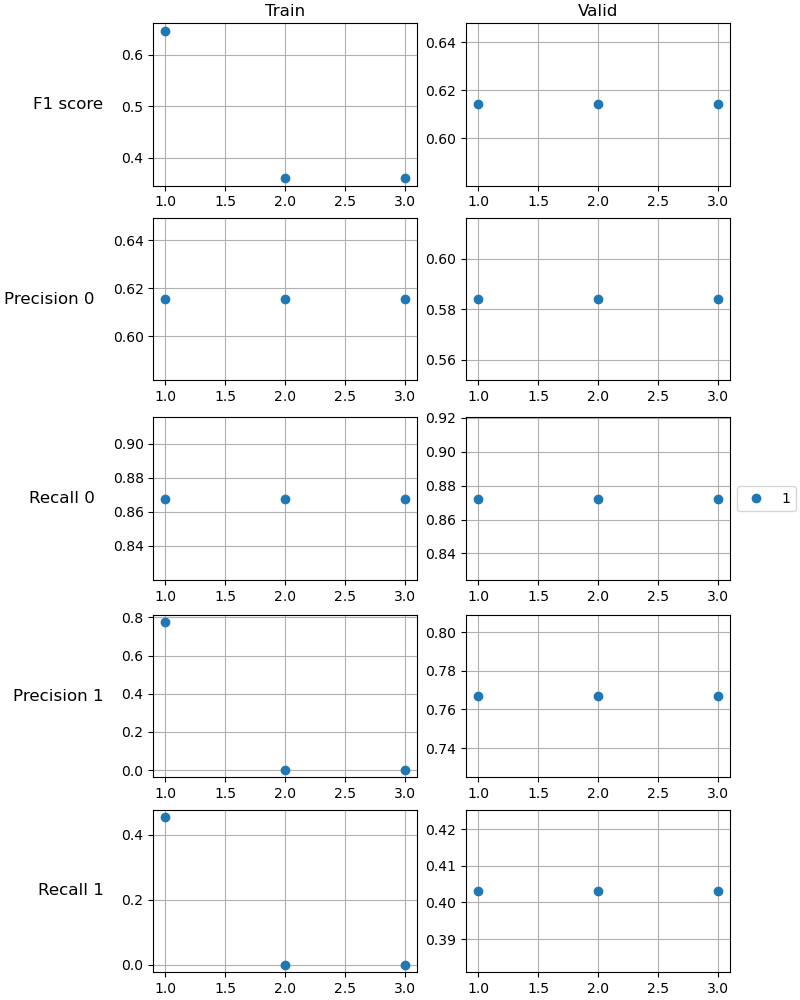

In [ ]:
%matplotlib widget

cols = ["Train", "Valid"]
rows = ["F1 score", "Precision 0", "Recall 0", "Precision 1", "Recall 1"]

figs = Figures([1, 2, 3], [x.reshape(1,-1) for x in d_metrics.values()], nrows=5, ncols=2, linestyle='None', marker='o')
figs.annotate(cols, rows)
figs.legend(row=2, col=1, loc='center left', bbox_to_anchor=(1, 0.5))
figs.plot_autocenter(False)
display(figs)